In [1]:
import numpy as np
from pprint import pprint
from copy import deepcopy


from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup
from laboneq.simple import *
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.calibration import Oscillator, SignalCalibration
from laboneq.dsl.enums import ModulationType




# descriptor = generate_descriptor(
#     #pqsc=[""], # 장비 여러개 사용시
#     shfqc_6=["DEV12256"], 
#     number_data_qubits=3,
#     multiplex=True,
#     number_multiplex=6,
#     include_cr_lines=False,
#     include_ef_lines=True,
#     get_zsync=False,  # Only set to True when using real device
#     save = True,
#     filename="1port",
#     ip_address="192.168.0.83"
# )


#descriptor
#setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
setup = DeviceSetup.from_yaml(filepath="/Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/Descriptors/1port.yaml" , server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments

In [2]:
bus_ids = [f"b{i}" for i in range(3)]
bus_port = [4,5,6] #used 1,2,3 for qubit drive

for i, bus in zip(bus_port,bus_ids):
    setup.add_connections(
        setup.instruments[0].uid,
        # each bus uses its own drive:
        create_connection(
            to_signal=f"{bus}/drive",
            ports=f"SGCHANNELS/{i}/OUTPUT"
        ))

# Calibrate qubit drive/measure lines for oscillator phase increments
qubit_ids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
for qubit in qubit_ids:
    for line, frequency, mod_type in [
        ("drive", 5e9, ModulationType.HARDWARE),
        ("drive_ef", 6e9, ModulationType.HARDWARE),
        ("measure", 4e9, ModulationType.SOFTWARE),
    ]:
        logical_signal = setup.logical_signal_by_uid(f"{qubit}/{line}")
        oscillator = Oscillator(modulation_type=mod_type)
        logical_signal.calibration = SignalCalibration(
            local_oscillator=Oscillator(frequency=frequency),
            oscillator=oscillator,
        )
        if line == "measure":
            acquire_signal = setup.logical_signal_by_uid(f"{qubit}/acquire")
            acquire_signal.calibration = SignalCalibration(
                local_oscillator=Oscillator(frequency=frequency),
                oscillator=oscillator,
            )


In [3]:
from qpu_types.fixed_transmon import FixedTransmonQubit, FixedTransmonQubitParameters
from qpu_types.bus_cavity import BusCavity, BusCavityParameters
from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from helper import load_qubit_parameters, save_qubit_parameters

qubit_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
bus_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("b")]

qubits = FixedTransmonQubit.from_device_setup(
    setup, qubit_uids=qubit_uids)
buses = BusCavity.from_device_setup(
    setup, qubit_uids=bus_uids)

qpu = QPU(quantum_elements={"qubits" : qubits, "bus" : buses}, quantum_operations=[FixedTransmonOperations, BusCavityOperations])


from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store") 
folder_store.activate()



In [4]:
import os
from datetime import datetime
def find_latest_json(folder_path):
    files = [f for f in os.listdir(folder_path)]
    timestamps = []
    for file in files:
        try:
            # Extract a timestamp assuming it's included in the filename
            timestamp_str = file.split('_', 1)[0]  # Assuming YYYYMMDDHHMMSS format
            timestamp = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')
            timestamps.append((timestamp, file))
        except ValueError:
            print("fuck")
            continue  # Skip files that do not match the timestamp format

       # Find the most recent file
    if timestamps:
        latest_file = max(timestamps, key=lambda x: x[0])[1]
        return os.path.join(folder_path, latest_file)
    return None

qb_pars_file = find_latest_json("./qpu_parameters/")
print(f"LOADED: {qb_pars_file}")

from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
import laboneq.dsl.quantum.qpu as qpu_mod

class CombinedOperations(FixedTransmonOperations, BusCavityOperations):
    pass

qpu_mod.CombinedOperations = CombinedOperations

qpu = load(qb_pars_file)

buses = qpu.groups.bus
qubits = qpu.groups.qubits


from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store")
folder_store.activate()

fuck
LOADED: ./qpu_parameters/20260211-2256_2q_qst


In [5]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=False, do_emulation=False)
#session.disconnect()

[2026.02.11 23:22:53.486] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2026.02.11 23:22:53.489] INFO    VERSION: laboneq 25.10.3
[2026.02.11 23:22:53.490] INFO    Connecting to data server at 192.168.0.83:8004
[2026.02.11 23:22:53.523] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2026.02.11 23:22:53.565] INFO    Configuring the device setup
[2026.02.11 23:22:53.681] INFO    The device setup is configured


## INTEGRATION Pipeline Validation (New)

아래 셀은 **DISCRIMINATION 경로 없이** `INTEGRATION + SINGLE_SHOT` 기반으로\n
`two_qubit_readout_calibration` -> `two_qubit_state_tomography` 분석이 동작하는지 검증합니다.


In [8]:
from experiments import two_qubit_readout_calibration
from experiments import two_qubit_state_tomography
import numpy as np

# Reuse existing variables from notebook: session, qpu, ctrl, targ, bus, temporary_parameters
if "ctrl" not in globals() or "targ" not in globals():
    ctrl = qubits[1]
    targ = qubits[0]
if "bus" not in globals():
    bus = buses[0]
if "temporary_parameters" not in globals():
    temporary_parameters = {}


def unwrap_output(obj):
    cur = obj
    for _ in range(24):
        if hasattr(cur, "output"):
            cur = cur.output
            continue
        return cur
    return cur


def _is_reference_like(obj):
    return obj is not None and obj.__class__.__name__ == "Reference"


def _contains_reference(obj, depth=0, max_depth=12):
    if depth > max_depth:
        return False
    cur = unwrap_output(obj)
    if _is_reference_like(cur):
        return True
    if isinstance(cur, dict):
        return any(_contains_reference(v, depth + 1, max_depth) for v in cur.values())
    if isinstance(cur, (list, tuple)):
        return any(_contains_reference(v, depth + 1, max_depth) for v in cur)
    return False


def _iter_tasks(node):
    tasks = getattr(node, "tasks", None)
    if tasks is None:
        return []
    try:
        return list(tasks)
    except Exception:
        return []


def _task_output(tasks, key):
    try:
        out = unwrap_output(tasks[key].output)
    except Exception:
        return None
    if _is_reference_like(out):
        return None
    return out


def _assemble_from_analysis_tasks(analysis_node):
    tasks = getattr(analysis_node, "tasks", None)
    if tasks is None:
        return None

    assignment = _task_output(tasks, "extract_assignment_matrix")
    tomography_counts = _task_output(tasks, "collect_tomography_counts")
    mle = _task_output(tasks, "maximum_likelihood_reconstruct")
    state_metrics = _task_output(tasks, "calculate_state_metrics")
    discriminator = _task_output(tasks, "fit_discriminator_from_readout_calibration")

    if not all(isinstance(x, dict) for x in [assignment, tomography_counts, mle, state_metrics, discriminator]):
        return None

    assembled = {
        "assignment_matrix": assignment.get("assignment_matrix"),
        "assignment_counts": assignment.get("counts_matrix_soft"),
        "assignment_counts_soft": assignment.get("counts_matrix_soft"),
        "assignment_counts_hard": assignment.get("counts_matrix_hard"),
        "tomography_counts": tomography_counts.get("counts"),
        "tomography_counts_hard": tomography_counts.get("counts_hard"),
        "setting_labels": tomography_counts.get("setting_labels"),
        "shots_per_setting": tomography_counts.get("shots_per_setting"),
        "rho_hat_real": mle.get("rho_hat_real"),
        "rho_hat_imag": mle.get("rho_hat_imag"),
        "predicted_probabilities": mle.get("predicted_probabilities"),
        "predicted_counts": mle.get("predicted_counts"),
        "optimizer_success": mle.get("optimizer_success"),
        "optimizer_message": mle.get("optimizer_message"),
        "negative_log_likelihood": mle.get("negative_log_likelihood"),
        "metrics": state_metrics,
        "discriminator_model": discriminator.get("model"),
        "classification_diagnostics": discriminator.get("diagnostics"),
        "bitflip_ctrl": False,
        "bitflip_targ": False,
    }
    return assembled


def _find_analysis_node(root, depth=0, max_depth=12):
    if root is None or depth > max_depth:
        return None
    tasks = _iter_tasks(root)
    if tasks:
        names = {getattr(t, "name", "") for t in tasks}
        if "maximum_likelihood_reconstruct" in names and "extract_assignment_matrix" in names:
            return root
        for t in tasks:
            found = _find_analysis_node(t, depth + 1, max_depth)
            if found is not None:
                return found
            found = _find_analysis_node(getattr(t, "output", None), depth + 1, max_depth)
            if found is not None:
                return found
    out = getattr(root, "output", None)
    if out is not None and out is not root:
        return _find_analysis_node(out, depth + 1, max_depth)
    return None


def extract_analysis_output(workflow_result):
    analysis_node = _find_analysis_node(workflow_result)
    if analysis_node is None:
        raise RuntimeError("Could not locate analysis workflow node.")

    out = unwrap_output(getattr(analysis_node, "output", None))
    if isinstance(out, dict) and not _contains_reference(out):
        return out

    assembled = _assemble_from_analysis_tasks(analysis_node)
    if isinstance(assembled, dict):
        return assembled

    raise RuntimeError("Could not materialize concrete analysis output from workflow tasks.")


# 1) Readout calibration acquisition (INTEGRATION + SINGLE_SHOT fixed by module)
readout_cal_result_new = two_qubit_readout_calibration.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=ctrl,
    targ=targ,
    temporary_parameters=temporary_parameters,
).run()

# 2) 2Q tomography with external readout calibration result
tomo_opts_new = two_qubit_state_tomography.experiment_workflow.options()
tomo_opts_new.do_analysis(True)
tomo_opts_new.do_readout_calibration(False)

bus_frequency = (
    bus.parameters.resonance_frequency_bus + (bus.parameters.rip_detuning or 0.0)
    if bus.parameters.resonance_frequency_bus is not None
    else 6.5e9
)
rip_amplitude = float(getattr(bus.parameters, "rip_amplitude", 0.0) or 0.0)
rip_length = float(getattr(bus.parameters, "rip_length", 64e-9) or 64e-9)

twoq_qst_result_new = two_qubit_state_tomography.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=ctrl,
    targ=targ,
    bus=bus,
    bus_frequency=bus_frequency,
    rip_amplitude=rip_amplitude,
    rip_length=rip_length,
    rip_phase=np.pi / 2,
    readout_calibration_result=readout_cal_result_new,
    target_state="++",
    options=tomo_opts_new,
    temporary_parameters=temporary_parameters,
).run()

out_new = unwrap_output(twoq_qst_result_new.output)
analysis_new = extract_analysis_output(twoq_qst_result_new)

print("top-level task names:", [t.name for t in twoq_qst_result_new.tasks])
print("workflow output type:", type(out_new).__name__)
print("analysis keys:", list(analysis_new.keys()))
print("fidelity_to_target:", analysis_new["metrics"].get("fidelity_to_target"))
print("classifier diagnostics:", analysis_new.get("classification_diagnostics", {}))



[2026.02.11 23:25:58.571] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.11 23:25:58.572] INFO      Workflow 'two_qubit_readout_calibration': execution started at 2026-02-11     
[2026.02.11 23:25:58.573] INFO      14:25:58.570066Z                                                              
[2026.02.11 23:25:58.573] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.11 23:25:58.580] INFO    Task 'temporary_qpu': started at 2026-02-11 14:25:58.579928Z
[2026.02.11 23:25:58.581] INFO    Task 'temporary_qpu': ended at 2026-02-11 14:25:58.581373Z
[2026.02.11 23:25:58.584] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-11 
[2026.02.11 23:25:58.585] INFO    14:25:58.584670Z
[2026.02.11 23:25:58.585] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-02-11 14:25:58.585717Z
[2026.02.11 23:25:58.587] INFO    Task 'temporary_quantum_elements_from_qpu': started

[2026.02.11 23:26:01.876] CRITICAL SHFQC/SG:dev12256: Attempt to configure channel 6 on a device with 6 channels. Verify your device setup.


[2026.02.11 23:26:01.877] ERROR   Task 'run_experiment': failed at 2026-02-11 14:26:01.877593Z with: 


[2026.02.11 23:26:01.877] ERROR   Task 'run_experiment': failed at 2026-02-11 14:26:01.877593Z with: 


[2026.02.11 23:26:01.878] ERROR   LabOneQControllerException('SHFQC/SG:dev12256: Attempt to configure channel 6 on


[2026.02.11 23:26:01.878] ERROR   LabOneQControllerException('SHFQC/SG:dev12256: Attempt to configure channel 6 on


[2026.02.11 23:26:01.878] ERROR   a device with 6 channels. Verify your device setup.')


[2026.02.11 23:26:01.878] ERROR   a device with 6 channels. Verify your device setup.')


[2026.02.11 23:26:01.879] INFO    Task 'run_experiment': ended at 2026-02-11 14:26:01.879211Z
[2026.02.11 23:26:01.879] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.11 23:26:01.880] INFO      Workflow 'two_qubit_state_tomography': execution ended at 2026-02-11          
[2026.02.11 23:26:01.880] INFO      14:26:01.879711Z                                                              
[2026.02.11 23:26:01.880] INFO     ────────────────────────────────────────────────────────────────────────────── 


LabOneQControllerException: SHFQC/SG:dev12256: Attempt to configure channel 6 on a device with 6 channels. Verify your device setup.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

A_soft = np.asarray(analysis_new["assignment_matrix"], dtype=float)
C_soft = np.asarray(analysis_new["assignment_counts_soft"], dtype=float)
C_hard = np.asarray(analysis_new["assignment_counts_hard"], dtype=float)

fig, axes = plt.subplots(1, 3, figsize=(15, 4.2))

im0 = axes[0].imshow(A_soft, vmin=0.0, vmax=1.0, cmap="Blues")
axes[0].set_title("Assignment matrix (soft)")
axes[0].set_xlabel("Prepared k")
axes[0].set_ylabel("Measured i")
axes[0].set_xticks(range(4), ["00", "01", "10", "11"])
axes[0].set_yticks(range(4), ["00", "01", "10", "11"])
fig.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(C_soft, cmap="viridis")
axes[1].set_title("Calibration counts (soft)")
axes[1].set_xlabel("Prepared k")
axes[1].set_ylabel("Measured i")
axes[1].set_xticks(range(4), ["00", "01", "10", "11"])
axes[1].set_yticks(range(4), ["00", "01", "10", "11"])
fig.colorbar(im1, ax=axes[1], fraction=0.046)

im2 = axes[2].imshow(C_hard, cmap="viridis")
axes[2].set_title("Calibration counts (hard, argmax)")
axes[2].set_xlabel("Prepared k")
axes[2].set_ylabel("Measured i")
axes[2].set_xticks(range(4), ["00", "01", "10", "11"])
axes[2].set_yticks(range(4), ["00", "01", "10", "11"])
fig.colorbar(im2, ax=axes[2], fraction=0.046)

fig.tight_layout()
plt.show()


## QST Validation Suite (Pass/Fail)

아래 셀은 `analysis_new`(또는 workflow 결과)로부터 2Q QST가 정상 동작하는지 자동 검증합니다.
- Assignment matrix 정규화/대각 우세
- Tomography counts 무결성
- 재구성 density matrix 물리성(Hermitian/trace/PSD)
- target fidelity 범위


In [ ]:
import numpy as np

def _fmt_bool(x):
    return 'PASS' if bool(x) else 'FAIL'

def validate_twoq_qst_analysis(analysis_dict, *, tol=1e-6):
    A = np.asarray(analysis_dict['assignment_matrix'], dtype=float)
    C_soft = np.asarray(analysis_dict['assignment_counts_soft'], dtype=float)
    C_hard = np.asarray(analysis_dict['assignment_counts_hard'], dtype=float)
    T_soft = np.asarray(analysis_dict['tomography_counts'], dtype=float)
    T_hard = np.asarray(analysis_dict['tomography_counts_hard'], dtype=float)
    shots = np.asarray(analysis_dict['shots_per_setting'], dtype=float)
    setting_labels = list(analysis_dict['setting_labels'])

    rho = np.asarray(analysis_dict['rho_hat_real'], dtype=float) + 1j*np.asarray(analysis_dict['rho_hat_imag'], dtype=float)

    checks = {}

    checks['assignment_shape_4x4'] = (A.shape == (4, 4))
    row_sums = A.sum(axis=1) if A.shape == (4, 4) else np.array([np.nan])
    checks['assignment_rows_sum_to_1'] = np.all(np.isfinite(row_sums)) and np.allclose(row_sums, 1.0, atol=5e-3)
    checks['assignment_diagonal_better_than_random'] = (np.trace(A)/4.0) > 0.25 if A.shape == (4, 4) else False

    checks['counts_nonnegative_finite'] = (
        np.all(np.isfinite(C_soft)) and np.all(np.isfinite(C_hard)) and
        np.all(np.isfinite(T_soft)) and np.all(np.isfinite(T_hard)) and
        np.all(C_soft >= -tol) and np.all(C_hard >= -tol) and
        np.all(T_soft >= -tol) and np.all(T_hard >= -tol)
    )

    checks['tomography_row_sum_matches_shots'] = (
        T_soft.shape[0] == shots.shape[0] and np.allclose(T_soft.sum(axis=1), shots, atol=max(1e-6, 5e-3*np.max(shots)))
    )
    checks['settings_count_consistent'] = (T_soft.shape[0] == len(setting_labels))

    checks['rho_shape_4x4'] = (rho.shape == (4, 4))
    herm_err = np.linalg.norm(rho - rho.conj().T) if rho.shape == (4, 4) else np.inf
    checks['rho_hermitian'] = herm_err < 1e-8
    tr = np.trace(rho) if rho.shape == (4, 4) else np.nan
    checks['rho_trace_1'] = np.isfinite(np.real(tr)) and abs(np.real(tr) - 1.0) < 1e-6
    min_eig = float(np.min(np.linalg.eigvalsh((rho + rho.conj().T)/2.0)).real) if rho.shape == (4, 4) else -np.inf
    checks['rho_psd'] = min_eig > -1e-6

    fidelity = analysis_dict.get('metrics', {}).get('fidelity_to_target', None)
    checks['fidelity_in_range_or_none'] = (fidelity is None) or (0.0 <= float(fidelity) <= 1.0)

    summary = {
        'assignment_avg_diag': float(np.trace(A)/4.0),
        'assignment_row_sums': row_sums.tolist(),
        'hermitian_error': float(herm_err),
        'rho_trace_real': float(np.real(tr)),
        'rho_min_eigenvalue': float(min_eig),
        'fidelity_to_target': None if fidelity is None else float(fidelity),
        'num_settings': int(T_soft.shape[0]),
        'shots_minmax': (float(np.min(shots)), float(np.max(shots))) if shots.size else (np.nan, np.nan),
    }

    overall_pass = all(bool(v) for v in checks.values())
    return checks, summary, overall_pass

analysis_for_validation = analysis_new if 'analysis_new' in globals() else extract_analysis_output(twoq_qst_result_new)
checks, summary, overall_pass = validate_twoq_qst_analysis(analysis_for_validation)

print('=== 2Q QST Validation Summary ===')
for k, v in checks.items():
    print(f'{_fmt_bool(v):4s} | {k}')
print('----------------------------------')
print('overall:', _fmt_bool(overall_pass))
print('assignment_avg_diag:', f"{summary['assignment_avg_diag']:.4f}")
print('assignment_row_sums:', np.round(summary['assignment_row_sums'], 4))
print('rho_trace_real:', f"{summary['rho_trace_real']:.8f}")
print('rho_min_eigenvalue:', f"{summary['rho_min_eigenvalue']:.3e}")
print('fidelity_to_target:', summary['fidelity_to_target'])
print('num_settings:', summary['num_settings'], 'shots[min,max]:', summary['shots_minmax'])
print('classifier diagnostics:', analysis_for_validation.get('classification_diagnostics', {}))


In [ ]:
A = np.asarray(analysis_new["assignment_matrix"], dtype=float)
print("col sums:", A.sum(axis=0))  # 이게 1에 가까워야 정상
print("row sums:", A.sum(axis=1))  # 필수 조건 아님


In [ ]:
# Optional repeatability check (set RUN_REPEAT = True to execute)
RUN_REPEAT = False
N_REPEAT = 3

if RUN_REPEAT:
    fids = []
    min_eigs = []
    diag_avgs = []
    pass_flags = []

    for rep in range(N_REPEAT):
        qst_rep = two_qubit_state_tomography.experiment_workflow(
            session=session,
            qpu=qpu,
            ctrl=ctrl,
            targ=targ,
            bus=bus,
            bus_frequency=bus_frequency,
            rip_amplitude=rip_amplitude,
            rip_length=rip_length,
            rip_phase=np.pi/2,
            readout_calibration_result=readout_cal_result_new,
            target_state='++',
            options=tomo_opts_new,
            temporary_parameters=temporary_parameters,
        ).run()

        an_rep = extract_analysis_output(qst_rep)
        checks_rep, summary_rep, ok_rep = validate_twoq_qst_analysis(an_rep)

        pass_flags.append(bool(ok_rep))
        diag_avgs.append(float(summary_rep['assignment_avg_diag']))
        min_eigs.append(float(summary_rep['rho_min_eigenvalue']))
        fid = summary_rep['fidelity_to_target']
        if fid is not None:
            fids.append(float(fid))

        print(f'Rep {rep+1}/{N_REPEAT}:', 'PASS' if ok_rep else 'FAIL',
              'diag=', f"{summary_rep['assignment_avg_diag']:.4f}",
              'min_eig=', f"{summary_rep['rho_min_eigenvalue']:.3e}",
              'fid=', summary_rep['fidelity_to_target'])

    print('\n=== Repeatability Summary ===')
    print('pass_rate:', f"{np.mean(pass_flags):.3f}")
    print('assignment_avg_diag: mean/std =', f"{np.mean(diag_avgs):.4f}", '/', f"{np.std(diag_avgs):.4f}")
    print('rho_min_eigenvalue: mean/std =', f"{np.mean(min_eigs):.3e}", '/', f"{np.std(min_eigs):.3e}")
    if len(fids) > 0:
        print('fidelity_to_target: mean/std =', f"{np.mean(fids):.4f}", '/', f"{np.std(fids):.4f}")
else:
    print('Set RUN_REPEAT = True to execute repeatability check.')


## Validation Mode Example (No RIP)

아래 셀은 `validation_mode=True`로 RIP 없이 `initial_state="++"`를 준비하고,
`target_state`는 자동으로 `++`로 맞춘 뒤 reconstructed density matrix를 ideal `++`와 비교합니다.


In [10]:
bus = buses[0]
bus

BusCavity(
│   uid='b0',
│   signals={
│   │   'drive': 'b0/drive'
│   },
│   parameters=BusCavityParameters(
│   │   custom={},
│   │   rip_amplitude=0.5,
│   │   rip_length=1e-06,
│   │   rip_pulse={
│   │   │   'function': 'NestedCosine'
│   │   },
│   │   rip_detuning=14000000.0,
│   │   drive_lo_frequency=5800000000.0,
│   │   drive_range=10,
│   │   spectroscopy_length=0.0001,
│   │   spectroscopy_amplitude=1,
│   │   spectroscopy_pulse={
│   │   │   'can_compress': True,
│   │   │   'function': 'const'
│   │   },
│   │   resonance_frequency_bus=5501600000.0,
│   │   kappa=None
│   )
)


[2026.02.11 23:28:59.412] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.11 23:28:59.414] INFO      Workflow 'two_qubit_state_tomography': execution started at 2026-02-11        
[2026.02.11 23:28:59.414] INFO      14:28:59.411961Z                                                              
[2026.02.11 23:28:59.415] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.11 23:28:59.421] WARNING Type <class 'laboneq.workflow.result.WorkflowResult'> not supported by the serializer [name: two_qubit_state_tomography.input.readout_calibration_result].
[2026.02.11 23:28:59.437] INFO    Task 'temporary_qpu': started at 2026-02-11 14:28:59.436995Z
[2026.02.11 23:28:59.438] INFO    Task 'temporary_qpu': ended at 2026-02-11 14:28:59.438227Z
[2026.02.11 23:28:59.444] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-11 
[2026.02.11 23:28:59.445] INFO    14:28:59.443281Z
[2026.02.11

/var/folders/jr/32xlwr6d0x7cdq4t8l4tq2600000gn/T/ipykernel_16645/2006889758.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


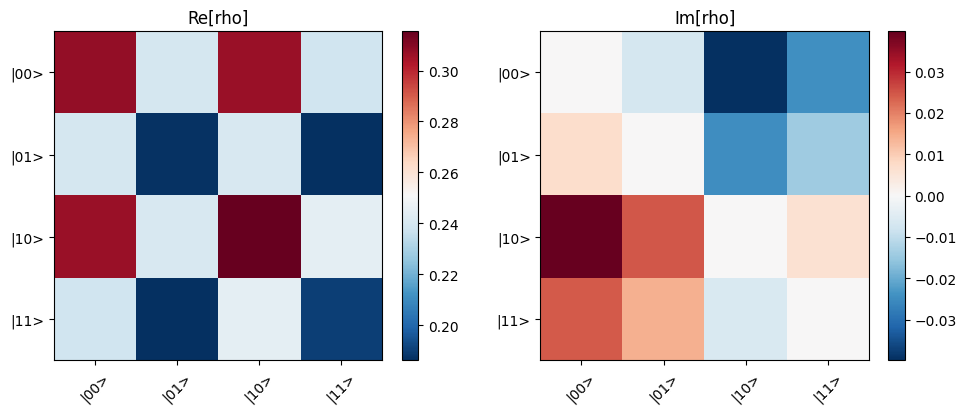

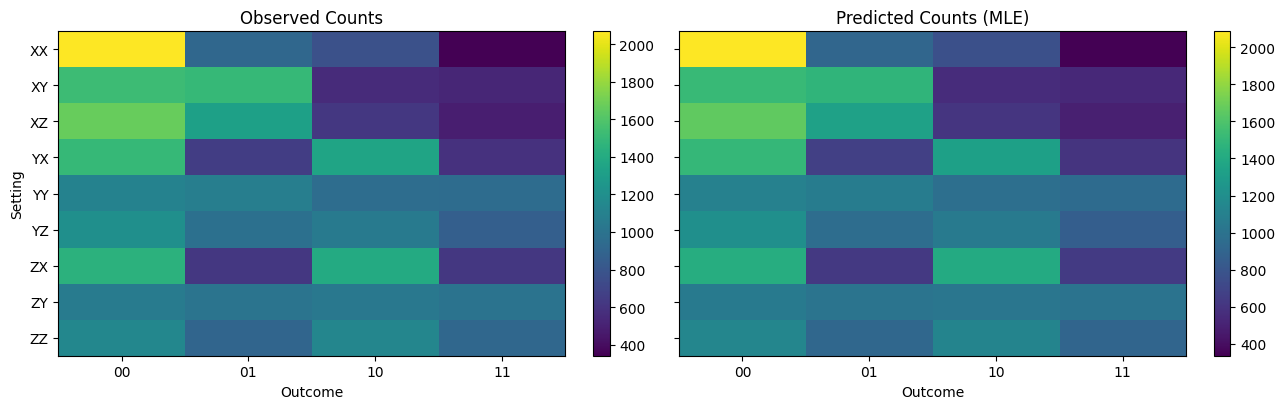

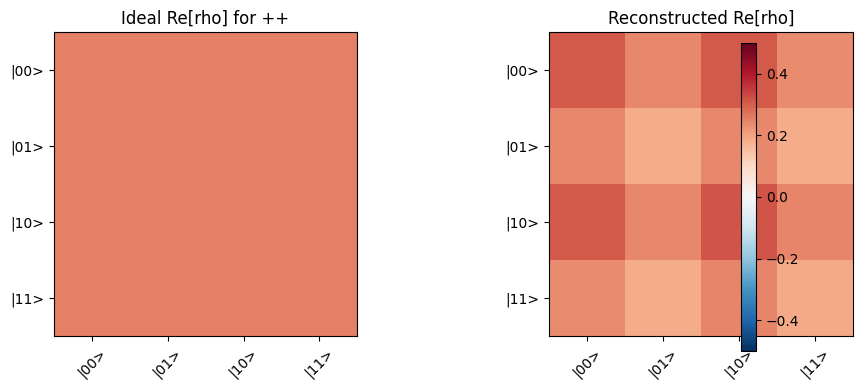

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from experiments import two_qubit_state_tomography

# Reuse existing variables if present
# if "ctrl" not in globals() or "targ" not in globals():
#     ctrl = qubits[1]
#     targ = qubits[0]
# if "bus" not in globals():
#     bus = buses[0]
# if "temporary_parameters" not in globals():
#     temporary_parameters = {}

# Use existing readout calibration result when available
readout_cal_for_val = None
if "readout_cal_result_new" in globals():
    readout_cal_for_val = readout_cal_result_new

opts_val = two_qubit_state_tomography.experiment_workflow.options()
opts_val.do_analysis(True)
opts_val.do_readout_calibration(True)
opts_val.validation_mode(True)
opts_val.use_rip(True)              # validation_mode=True 이면 자동으로 RIP 미사용
opts_val.initial_state("++")
opts_val.enforce_target_match(True)

bus_frequency = (
    bus.parameters.resonance_frequency_bus + (bus.parameters.rip_detuning or 0.0)
    if bus.parameters.resonance_frequency_bus is not None
    else 6.5e9
)
rip_amplitude = float(getattr(bus.parameters, "rip_amplitude", 0.0) or 0.0)
rip_length = float(getattr(bus.parameters, "rip_length", 64e-9) or 64e-9)

wf_val = two_qubit_state_tomography.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=ctrl,
    targ=targ,
    bus=bus,
    bus_frequency=bus_frequency,
    rip_amplitude=rip_amplitude,
    rip_length=rip_length,
    rip_phase=np.pi/2,
    readout_calibration_result=readout_cal_for_val,
    target_state=None,
    options=opts_val,
    temporary_parameters=temporary_parameters,
).run()




validation_mode: Reference(ref=task(name=resolve_validation_configuration), default=<object object at 0x133988d10>)
used_rip: Reference(ref=task(name=resolve_validation_configuration), default=<object object at 0x133988d10>)
target_state_effective: Reference(ref=task(name=resolve_validation_configuration), default=<object object at 0x133988d10>)
fidelity_to_++: 0.9776824779157073


/var/folders/jr/32xlwr6d0x7cdq4t8l4tq2600000gn/T/ipykernel_16645/2089230431.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


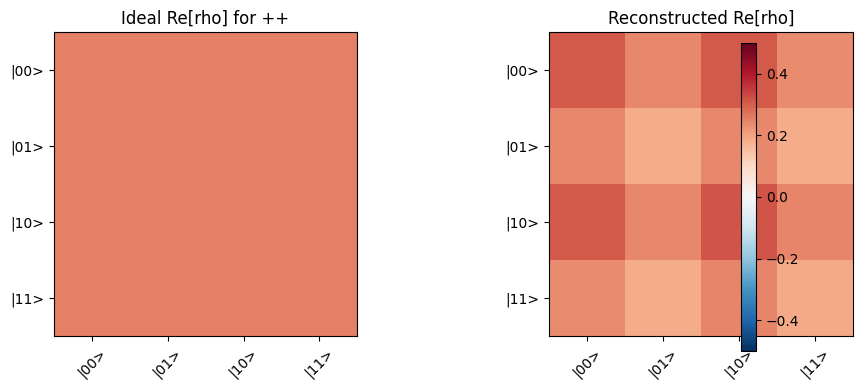

In [13]:
analysis_val = extract_analysis_output(wf_val)
rho_hat = np.asarray(analysis_val["rho_hat_real"], dtype=float) + 1j*np.asarray(analysis_val["rho_hat_imag"], dtype=float)
rho_hat = (rho_hat + rho_hat.conj().T) / 2.0
rho_hat /= np.trace(rho_hat)

psi_pp = np.array([1,1,1,1], dtype=complex) / 2.0
rho_ideal = np.outer(psi_pp, psi_pp.conj())
fidelity_pp = float(np.real(np.conjugate(psi_pp) @ rho_hat @ psi_pp))

print("validation_mode:", unwrap_output(wf_val.output).get("validation_mode", "n/a"))
print("used_rip:", unwrap_output(wf_val.output).get("used_rip", "n/a"))
print("target_state_effective:", unwrap_output(wf_val.output).get("target_state_effective", "n/a"))
print("fidelity_to_++:", fidelity_pp)

labels = ["|00>","|01>","|10>","|11>"]
fig, axes = plt.subplots(1, 2, figsize=(10, 4.0))
im0 = axes[0].imshow(rho_ideal.real, vmin=-0.5, vmax=0.5, cmap="RdBu_r")
axes[0].set_title("Ideal Re[rho] for ++")
axes[0].set_xticks(range(4), labels, rotation=45)
axes[0].set_yticks(range(4), labels)

im1 = axes[1].imshow(rho_hat.real, vmin=-0.5, vmax=0.5, cmap="RdBu_r")
axes[1].set_title("Reconstructed Re[rho]")
axes[1].set_xticks(range(4), labels, rotation=45)
axes[1].set_yticks(range(4), labels)

fig.colorbar(im1, ax=axes.ravel().tolist(), fraction=0.035)
fig.tight_layout()
plt.show()